In [ ]:
!pip install nelson_siegel_svensson
!pip install QuantLib

In [ ]:
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, errorfn_ns_ols
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
import QuantLib as ql

In [ ]:
# Get reference date from web
def GET_DATE():
    req = requests.get("https://www.marketwatch.com/investing/bond/tmubmusd10y?countrycode=bx")
    html = req.text
    soup = BeautifulSoup(html, 'html.parser')
    data = soup.find("span", class_="timestamp__time")
    date = data.text
    date = date[14:-15]
    date = datetime.datetime.strptime(date, "%b %d, %Y").date()
    return date

In [ ]:
# Get prices and etcs that are necessary from web
# QuantLib needs different kinds of datas to draw yield curve(for note and bond price and coupon and for bill only interest rates)
def GET_QUOTE(reference_date):
    tenors = ['01M', '03M', '06M', '01Y', '02Y', '03Y', '05Y', '07Y', '10Y', '30Y']
    
    maturities = []
    days = []
    prices = []
    coupons = []
    
    for i, tenors in enumerate(tenors):
        req = requests.get("https://www.marketwatch.com/investing/bond/tmubmusd" + tenors + "?countryCode=BX")
    
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')

        data1 = soup.select('body > div > div > div > div > div > h2 > span')
        data2 = soup.select('body > div > div > div > div > div > ul > li > span')
        
        if i <= 3:
            price = data1[0].text
            price = float(price)
        else:  
            price = data2[6].text
            price = price.split()
            price1 = float(price[0])
            price = price[1].split('/')
            price2 = float(price[0])
            price3 = float(price[1])
            price = price1 + (price2 / price3)
        
        coupon = data2[12].text
        if coupon != '':
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
            
        maturity = data2[14].text
        maturity = datetime.datetime.strptime(maturity, '%b %d, %Y').date()
        
        days.append((maturity - reference_date).days)
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
    
    df = pd.DataFrame([maturities, days, prices, coupons]).transpose()
    headers = ['maturity', 'days', 'price', 'coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)
    
    return df

In [ ]:
ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
quote

,days,price,coupon
maturity,,,
2021-09-28,32,0.038,0
2021-11-26,91,0.053,0
2022-02-24,181,0.053,0
2022-08-11,349,0.069,0
2023-08-31,734,99.25,0.125
2024-08-15,1084,99.2812,0.375
2026-08-31,1830,99.2188,0.75
2028-08-31,2561,100.062,1.125
2031-08-15,3640,99.125,1.25


In [ ]:
def TREASURY_CURVE(date, quote):
    
    tbill = quote[0:4]
    tbond = quote[4:]
    
    eval_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = eval_date
    
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    day_counter = ql.ActualActual()
    end_of_month = True
    fixing_days = 1
    face_amount = 100
    coupon_frequency = ql.Period(ql.Semiannual)
    
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                         ql.Period(m, ql.Days),
                                         fixing_days,
                                         calendar,
                                         convention,
                                         end_of_month,
                                         day_counter)
                    for r, m in zip(tbill['price'], tbill['days'])]
    
    bond_helpers = []
    for p, c, m in zip(tbond['price'], tbond['coupon'], tbond['days']):
        termination_date = eval_date + ql.Period(m, ql.Days)
        schedule = ql.Schedule(eval_date,
                               termination_date,
                               coupon_frequency,
                               calendar,
                               convention,
                               convention,
                               ql.DateGeneration.Backward,
                               end_of_month)
        bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(p)),
                                             fixing_days,
                                             face_amount,
                                             schedule,
                                             [c/100.0],
                                             day_counter,
                                             convention)
        bond_helpers.append(bond_helper)
    
    rate_helper = bill_helpers + bond_helpers
    
    yc_linearzero = ql.PiecewiseLinearZero(eval_date, rate_helper, day_counter)
    
    return yc_linearzero

In [ ]:
def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

In [ ]:
def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.ActualActual()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(date, day_counter, compounding, freq).rate()
    return zero_rate

In [ ]:
ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
curve = TREASURY_CURVE(ref_date, quote)

curve

<QuantLib.QuantLib.PiecewiseLinearZero; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLinearZero > *' at 0x7fe0202b2480> >

            discount factor  zero rate
maturity                              
2021-09-28         0.999967   0.000380
2021-11-26         0.999888   0.000449
2022-02-24         0.999739   0.000527
2022-08-11         0.999444   0.000581
2023-08-31         0.990005   0.005002
2024-08-15         0.981791   0.006201
2026-08-31         0.955367   0.009133
2028-08-31         0.924315   0.011256
2031-08-15         0.873350   0.013633
2051-08-15         0.541666   0.020564


Text(0, 0.5, 'Discount Factor')

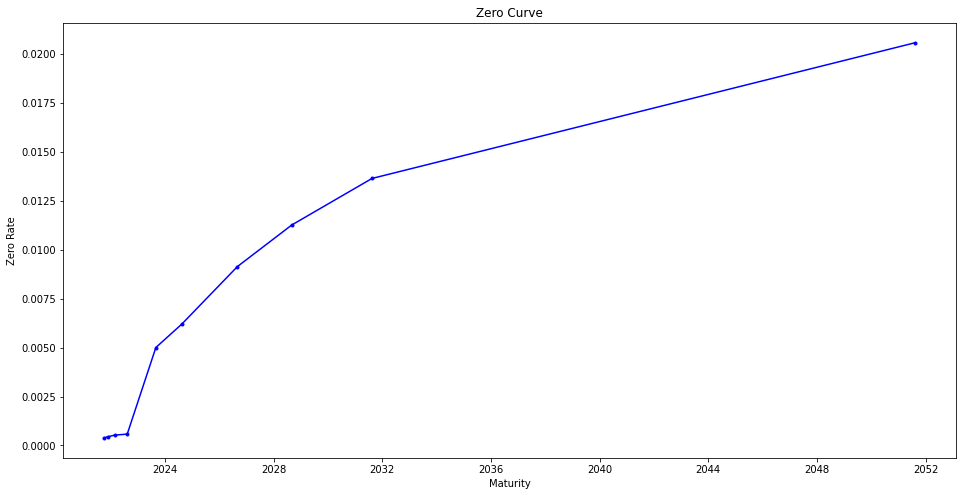

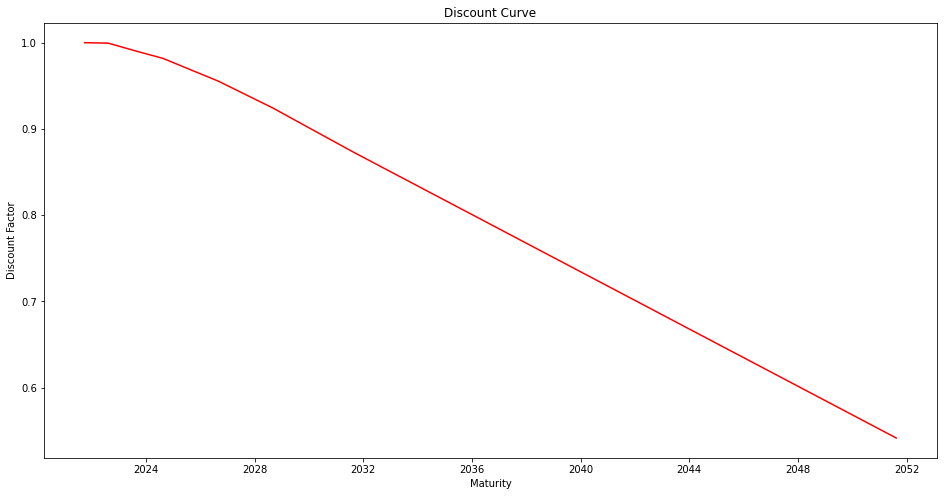

In [ ]:
ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
curve = TREASURY_CURVE(ref_date, quote)

quote['discount factor'] = np.nan
quote['zero rate'] = np.nan

for date in quote.index:
    quote.loc[date, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
    quote.loc[date, 'zero rate'] = ZERO_RATE(date, curve)
    
print(quote[['discount factor', 'zero rate']])

plt.figure(figsize=(16,8))
plt.plot(quote['zero rate'], 'b.-')
plt.title('Zero Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Zero Rate')

plt.figure(figsize=(16,8))
plt.plot(quote['discount factor'], 'r-')
plt.title('Discount Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')

In [ ]:
t = np.array([1/12, 3/12, 6/12, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 30.0])
y = quote['zero rate'].to_numpy()

Text(0, 0.5, 'Zero rate')

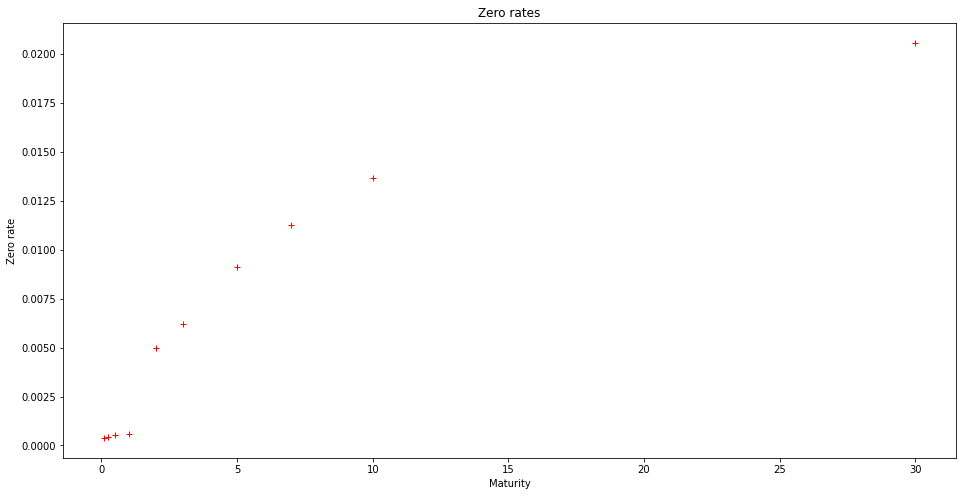

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(t, y, 'r+')
plt.title('Zero rates', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Zero rate')

In [ ]:
curve, status = calibrate_ns_ols(t, y, tau0=1.0)  # starting value of 1.0 for the optimization of tau
assert status.success
curve

NelsonSiegelCurve(beta0=0.022063161286998603, beta1=-0.02189863269109793, beta2=-0.018945279861738027, tau=1.8340690083318218)

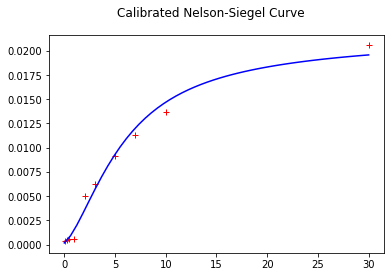

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Calibrated Nelson-Siegel Curve')
ax.plot(t, y, 'r+')
t2 = np.linspace(0, 30)
ax.plot(t2, curve(t2), 'b-')